In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from sklearn.neighbors import LocalOutlierFactor


In [5]:
class Recons(nn.Module):
    def __init__(self, n_input,n_output):
        super(Recons,self).__init__()
        
        self.encode1 = nn.Sequential(nn.Linear(n_input,10),
                                    nn.Dropout(0.7),
                                    nn.Tanh(),
                                    
                                    nn.Linear(10,9),
                                    nn.Dropout(0.7),
                                    nn.Tanh(),
                                     
                                    nn.Linear(9,9),
                                     nn.Dropout(0.7),
                                     nn.Tanh(),
                                     
                                     nn.Linear(9,10),
                                     nn.Dropout(0.7),
                                     nn.Tanh(),
                                    )
        self.decode1 = nn.Sequential(nn.Linear(10,9),
                                    nn.Dropout(0.7),
                                    nn.Tanh(),
                                    
                                    nn.Linear(9,9),
                                    nn.Dropout(0.7),
                                    nn.Tanh(),
                                    
                                    nn.Linear(9,10),
                                    nn.Dropout(0.7),
                                    nn.Tanh(),
                                    
                                    nn.Linear(10,n_output),)
        
    def forward(self,x):
        ed1 = self.encode1(x)
        
        de1 = self.decode1(ed1)

        loss = []
        for i in range(x.shape[0]):
            loss.append(torch.mean(torch.pow((x-de1),2)))

        
        return x, de1, torch.tensor(loss)

In [6]:
df = pd.read_csv('Embedding_Netwokr.csv',header = None).values

In [7]:
lof = LocalOutlierFactor(n_neighbors = 90, contamination = 0.23,algorithm = 'auto',n_jobs = -1,novelty= True)
lof.fit(df)
y_pred = lof.predict(df)

In [8]:
df_tensor = torch.tensor(df,dtype = torch.float32)
Pr_tensor = torch.tensor(y_pred).type(torch.LongTensor)

In [9]:
Pr_tensor

tensor([ 1, -1,  1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        -1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
         1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1, -1,
         1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        -1,  1, -1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1])

In [10]:
indices_1 = [i for i, x in enumerate(Pr_tensor) if x == 1]
indices_0 = [i for i, x in enumerate(Pr_tensor) if x == -1]

In [11]:
X_train = []
X_test = []
for i in indices_1:
    X_train.append(df[i])
for i in indices_0:
    X_test.append(df[i])

df_train = torch.tensor(np.array(X_train)).type(torch.FloatTensor)
df_test  = torch.tensor(np.array(X_test)).type(torch.FloatTensor)

In [12]:
Autoencoder = Recons(df_train.shape[1],df_train.shape[1])

In [13]:
optimizer = torch.optim.Adam(Autoencoder.parameters(), lr=0.005)
loss_func = nn.MSELoss()

In [14]:
for i in range(10):
    x, de1, loss1 = Autoencoder(df_train)
    loss = loss_func(x,de1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('Epoch: ',i, '|' ,'Traininng loss is %.4f' %loss.data.numpy())

Epoch:  0 | Traininng loss is 0.0945
Epoch:  1 | Traininng loss is 0.0908
Epoch:  2 | Traininng loss is 0.0811
Epoch:  3 | Traininng loss is 0.0713
Epoch:  4 | Traininng loss is 0.0718
Epoch:  5 | Traininng loss is 0.0661
Epoch:  6 | Traininng loss is 0.0595
Epoch:  7 | Traininng loss is 0.0585
Epoch:  8 | Traininng loss is 0.0561
Epoch:  9 | Traininng loss is 0.0510


In [15]:
x_te, de1_te, loss_te = Autoencoder(df_test)
loss_te, loss1

(tensor([0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461,
         0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461,
         0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461, 0.0461,
         0.0461, 0.0461]),
 tensor([0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510,
         0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510,
         0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510,
         0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510,
         0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510,
         0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510,
         0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510,
         0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510,
         0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510, 0.0510,
 

In [16]:
from sklearn.decomposition import PCA
from pylab import plt, mpl
from sklearn.metrics import classification_report
import heapq

np.random.seed(100)
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 500
mpl.rcParams['font.family'] = 'serif'

In [17]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X = np.concatenate([X_train,X_test])
Loss_con = np.concatenate([loss1.data.numpy(),loss_te.data.numpy()+0.2])

mean = 0  # 噪声的均值
std = 0.01  # 噪声的标准差
num_samples = len(Loss_con)
noise = np.random.normal(mean, std, num_samples)

# 添加噪声到原始数据上
noisy_data = [x + y for x, y in zip(Loss_con, np.abs(noise))]
print(noisy_data)

[0.06853966015027811, 0.05446880945300616, 0.06257236344536758, 0.05356636578494504, 0.060855213289243454, 0.05618419383367496, 0.053253802111945144, 0.06174243872541407, 0.052936963727962895, 0.05359201986246496, 0.05562227527475738, 0.05539364030096006, 0.05687795592295779, 0.05921047613658893, 0.05776921347682775, 0.05208611685363742, 0.05635480918825024, 0.0613393322710646, 0.05542336164677531, 0.0622251878822855, 0.06723182202648373, 0.0664580571648652, 0.05356079681186327, 0.05946636280224411, 0.05288719232537057, 0.06041282743082066, 0.05835200885807923, 0.06465756667118445, 0.05430438601175416, 0.05159876556827891, 0.05326600150528419, 0.06547417537198451, 0.058605528475675496, 0.059206545529924, 0.05854645303507293, 0.055601474694411165, 0.06293822810002239, 0.06794817368356718, 0.06460599590834426, 0.0633663505588804, 0.056486397036455784, 0.05772372278786542, 0.05111515105202017, 0.05717139277451277, 0.06403948616728423, 0.06837296165626396, 0.06087510641102744, 0.0546170829

In [18]:
pca = PCA(n_components = 2)
x_pca = pca.fit_transform(X)
pca1 = PCA(n_components = 1)
x_pca1 = pca1.fit_transform(X)

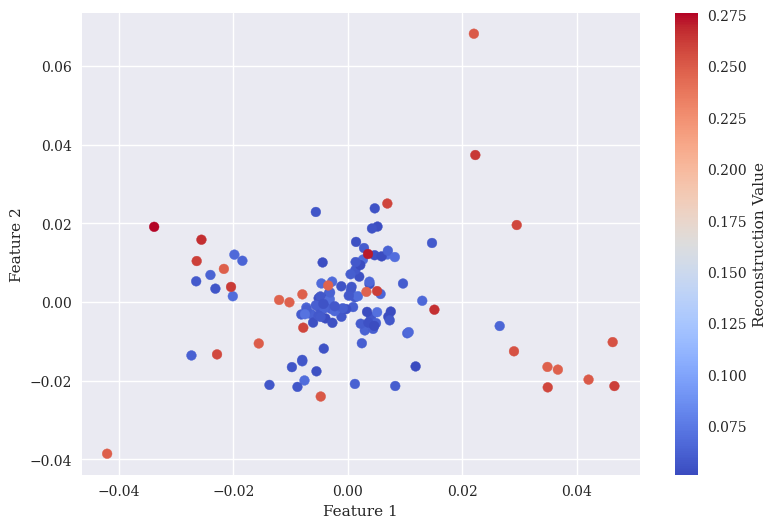

In [19]:
plt.figure(figsize=(9, 6))
fig = plt.scatter(x_pca[:, 0], x_pca[:, 1],
                  c=noisy_data, cmap='coolwarm')
cb = plt.colorbar(fig)
cb.set_label('Reconstruction Value')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
#plt.savefig('Fig-Visulation.svg', dpi = 500, format='svg')
plt.show()
#plt.title('');

In [20]:
cen = np.array(([np.mean(x_pca[:,0]),np.mean(x_pca[:,1])]))
cen

array([-3.46944695e-17, -1.65211760e-17])

In [21]:
def ed(m, n):
    return np.sqrt(np.sum((m - n) ** 2))

In [22]:
dis = []
for i in range(x_pca.shape[0]):
    dis.append(ed(x_pca[i],cen))
dis = np.array(dis)

In [168]:
top10 = heapq.nlargest(int(X.shape[0]*0.28), range(len(dis)), dis.take)
top = np.array(top10).reshape(1,-1)
top

array([[112, 104, 125, 109, 114, 100, 101, 111, 102, 106, 113, 117,   7,
        121, 122,  38,  67, 123, 115,  66,  36, 105,  71,  55,  35,  43,
         98,  21,  83,   0,  77,  32,  79, 116,  42]])

In [169]:
r = ed(x_pca[top[0][-1]],cen)
gd = []
c = 0
for i in range(dis.shape[0]):
    if dis[i] >= r:
        gd.append(-1)
    else:
        gd.append(1)
gd = np.array(gd)

In [182]:
lof = LocalOutlierFactor(n_neighbors = 99, contamination = 0.35,algorithm = 'auto',n_jobs = -1,novelty= True)
lof.fit(df)
y_pred = lof.predict(df)